In [1]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

from jupyterthemes import jtplot
jtplot.style()

%matplotlib inline
%load_ext autotime
%load_ext line_profiler
%matplotlib inline 

# Data Load

In [100]:
# Load data
properties_data = pd.read_csv('../Data/properties_2016.csv', low_memory=False)
# Load train data
train_data = pd.read_csv('../Data/train_2016_v2.csv')
# Elements to be forecasted - this is the framework
submission_sample = pd.read_csv('../Data/sample_submission.csv')
# Load label description and feature documentation
label_documentation = pd.read_csv('../Data/zillow_data_dictionary.csv', encoding='ISO8859_1')
# Replace null values, identify duplicates.
properties_data = properties_data.fillna(0)
transactions = pd.merge(train_data, properties_data, how='left', on=['parcelid'])
duplicate_records = train_data[train_data['parcelid'].duplicated()]['parcelid'].unique()

time: 36.2 s


# Visualisation

/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


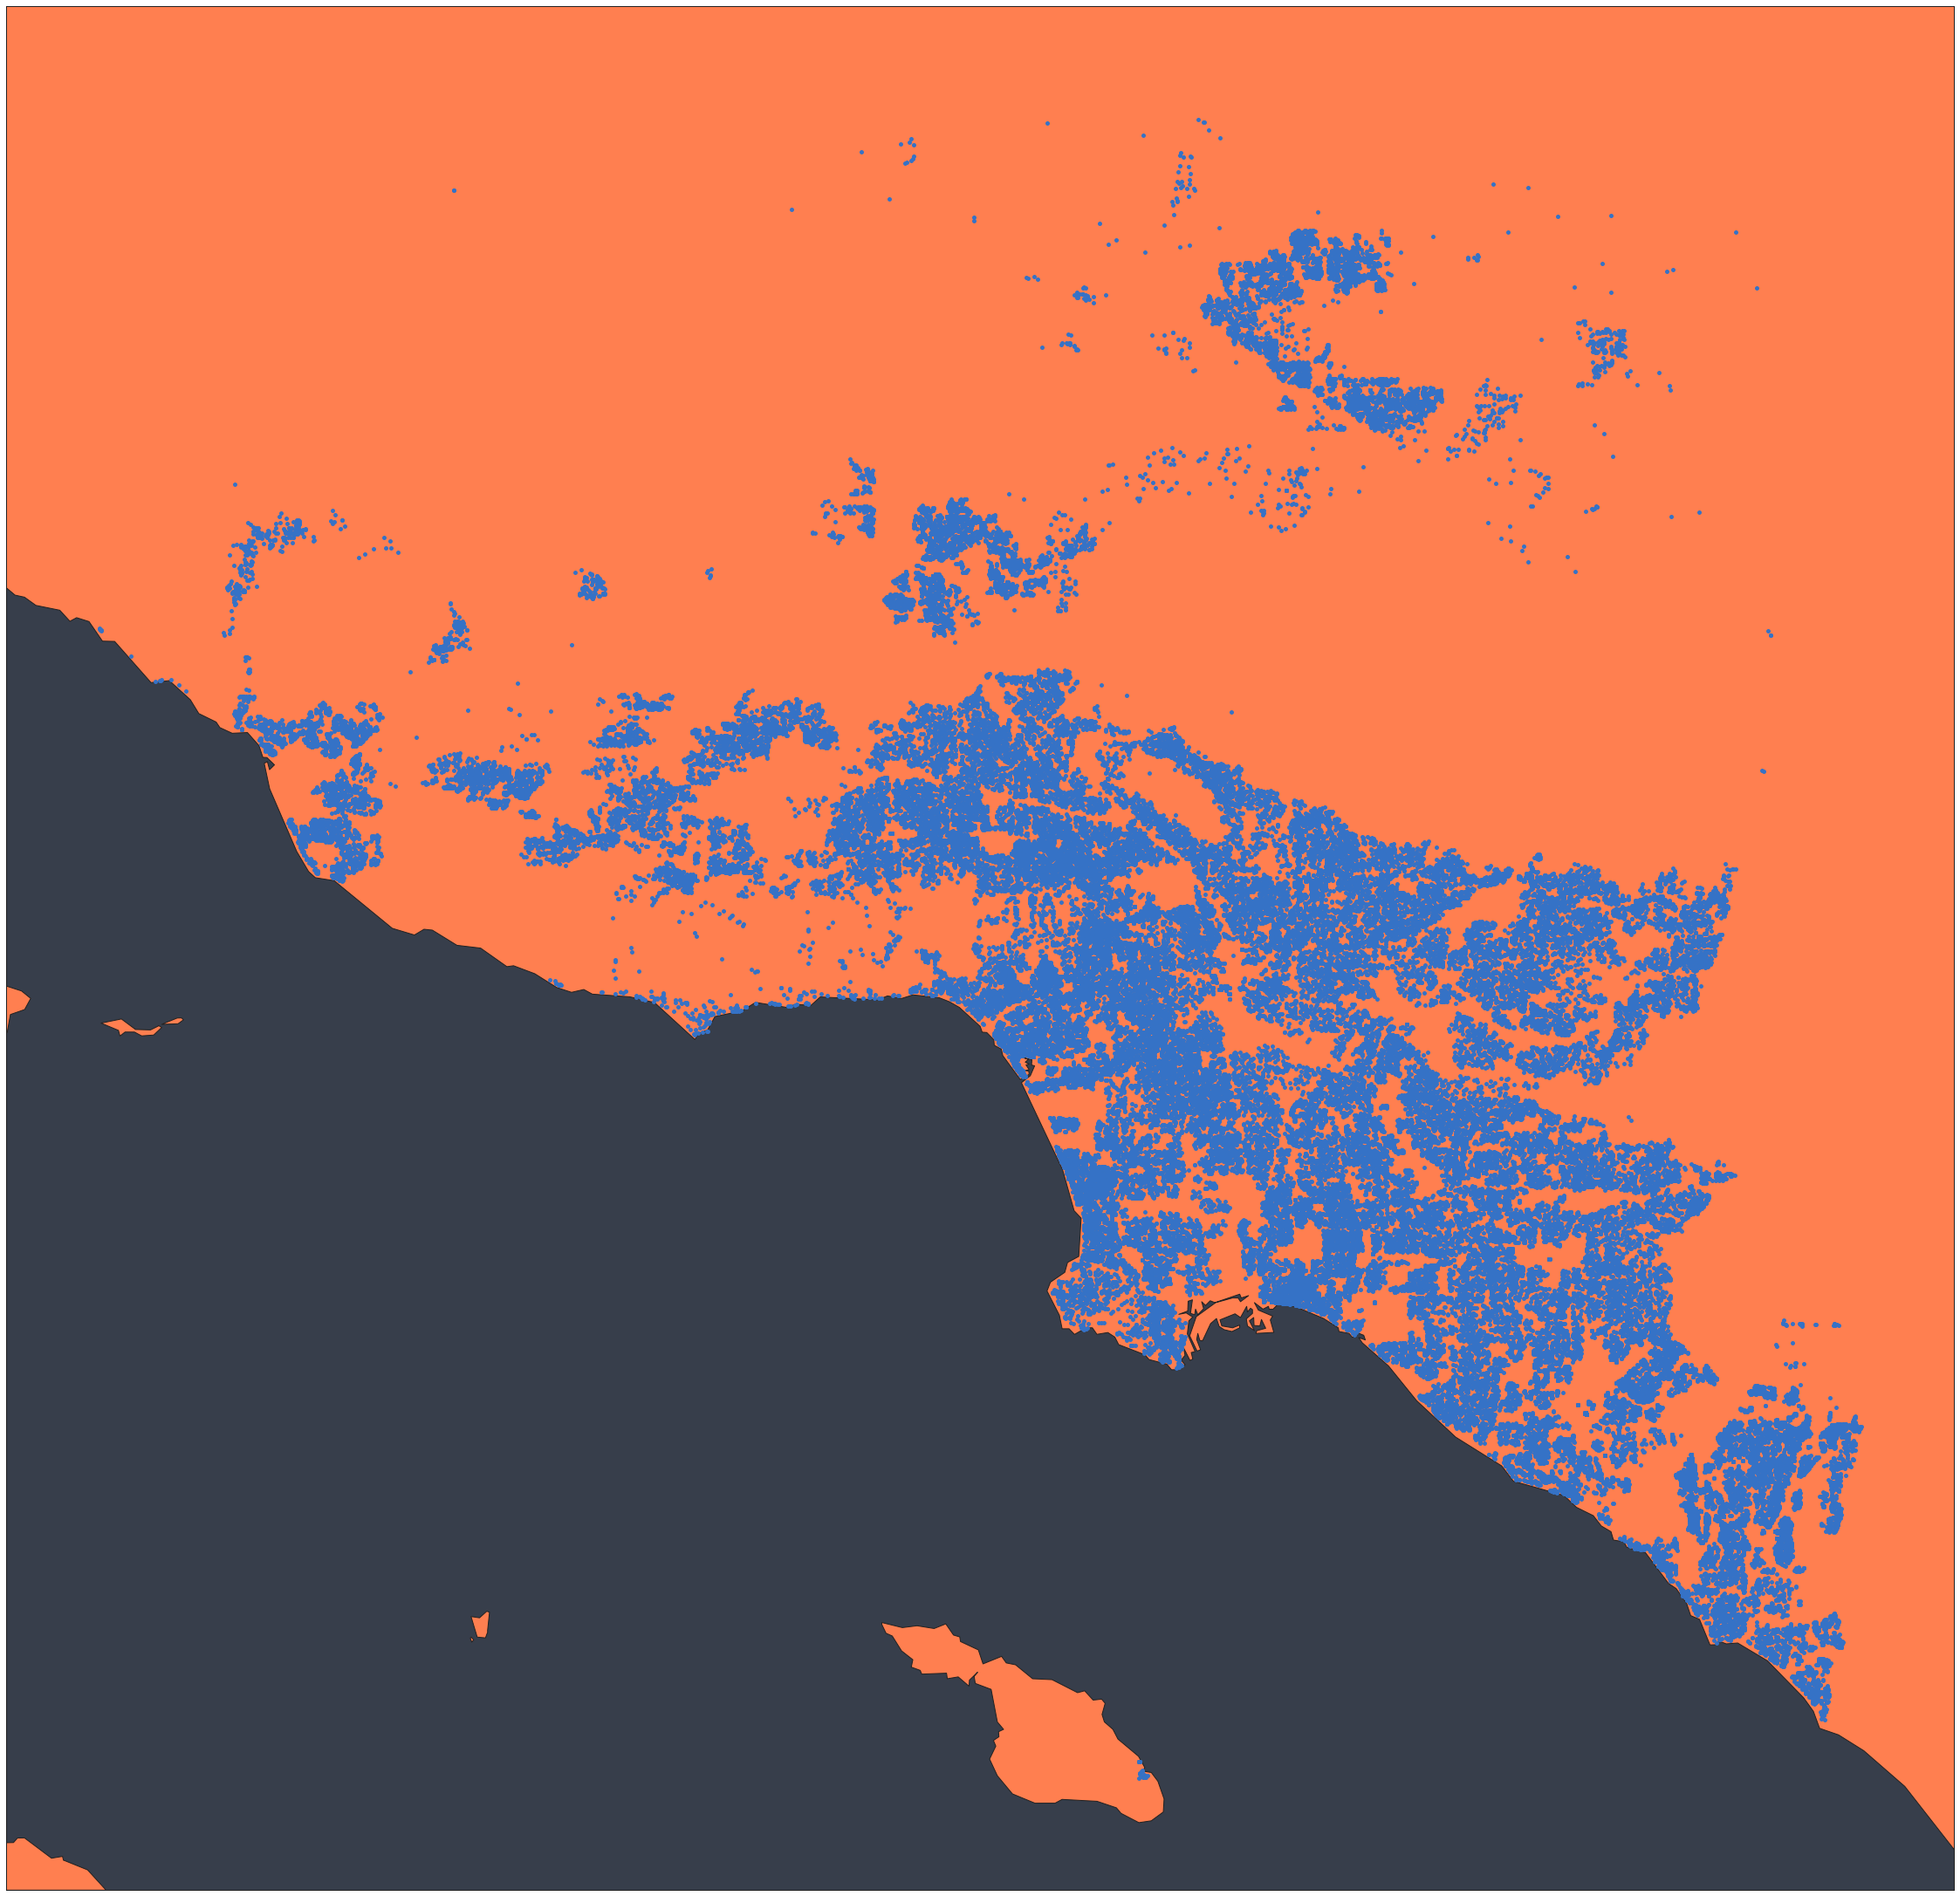

time: 23 s


In [101]:
transactions['latitude'] = transactions['latitude']/1000000
transactions['longitude'] = transactions['longitude']/1000000

# Get latitude and longitude extremes
min_lat = transactions['latitude'].min()
max_lat = transactions['latitude'].max()
min_lon = transactions['longitude'].min()
max_lon = transactions['longitude'].max()

# Build map
area = 0.1
fig = plt.figure(figsize=(40,40))
map = Basemap(projection='merc', lat_0 = np.mean([min_lat, max_lat]), lon_0 = np.mean([min_lon, max_lon]),
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=min_lon - area, llcrnrlat=min_lat - area,
    urcrnrlon=max_lon + area, urcrnrlat=max_lat + area)
 
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = 'coral')
map.drawmapboundary()
 
lon = transactions['longitude'].values
lat = transactions['latitude'].values
x,y = map(lon, lat)
map.plot(x, y, 'bo', markersize=5)

In [102]:
label_documentation

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (i...
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, ..."
2,'basementsqft',Finished living area below or partially below...
3,'bathroomcnt',Number of bathrooms in home including fractio...
4,'bedroomcnt',Number of bedrooms in home
5,'buildingqualitytypeid',Overall assessment of condition of the buildi...
6,'buildingclasstypeid',"The building framing type (steel frame, wood f..."
7,'calculatedbathnbr',Number of bathrooms in home including fractio...
8,'decktypeid',Type of deck (if any) present on parcel
9,'threequarterbathnbr',Number of 3/4 bathrooms in house (shower + si...


time: 12.8 ms


In [103]:
# Information about the distribution of 'logerror'
transactions['logerror'].describe()

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64

time: 8.26 ms


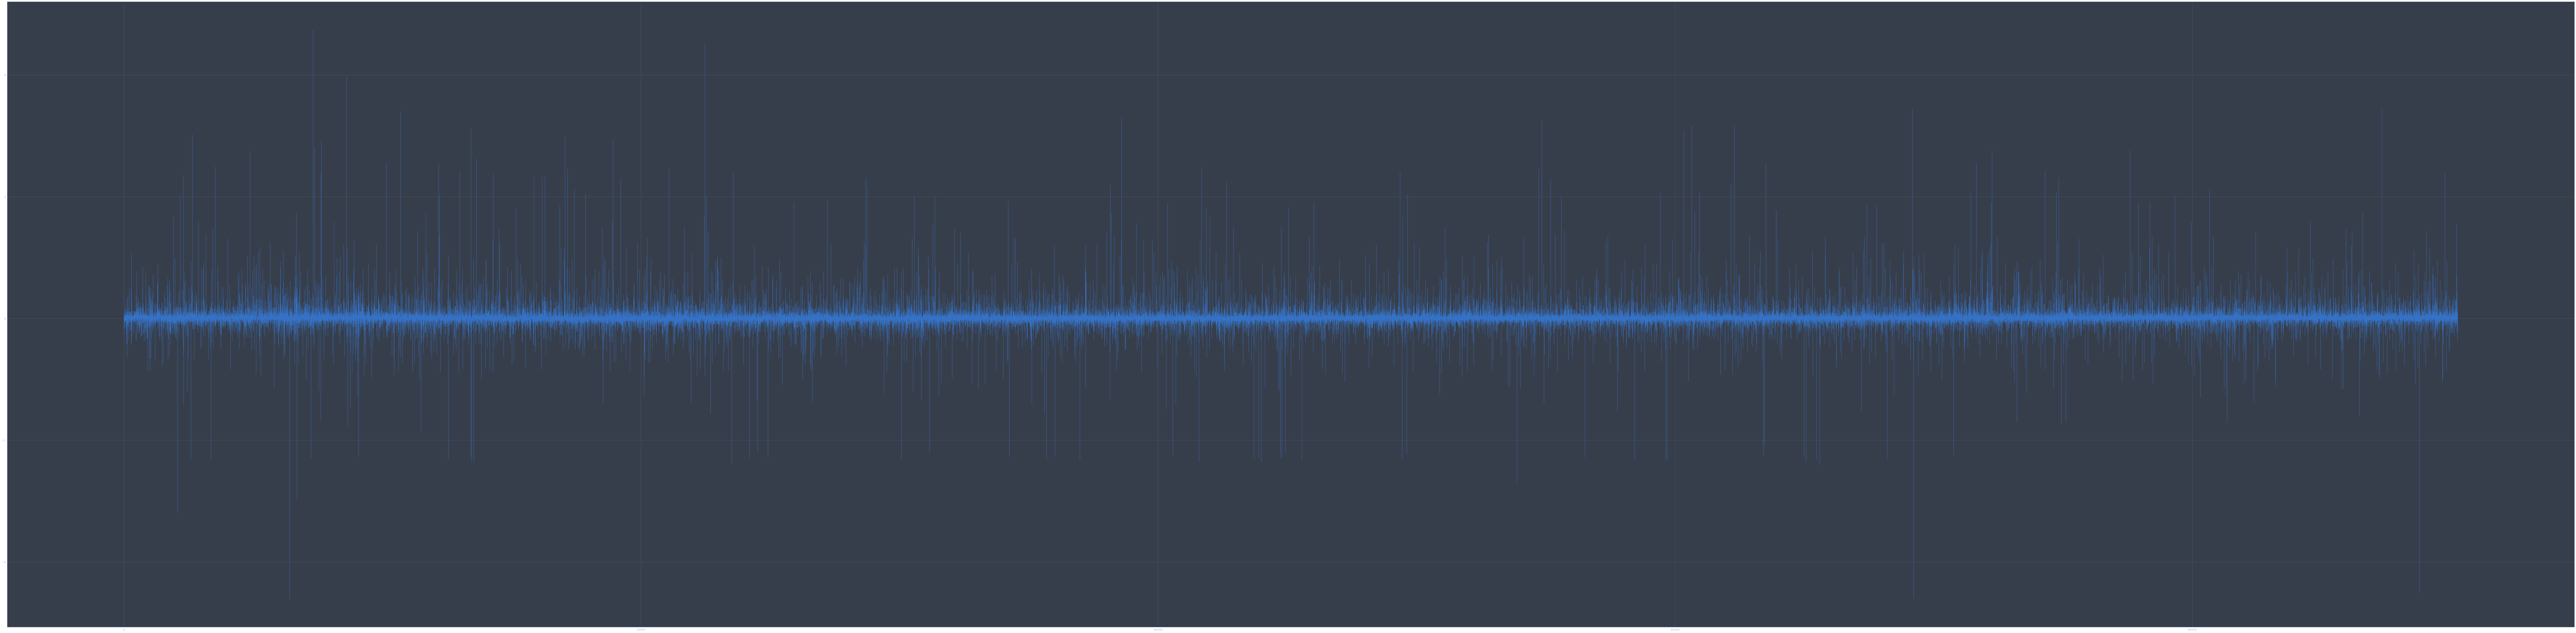

time: 11.3 s


In [104]:
fig = plt.figure(figsize=(200,50))
plt.plot(transactions['logerror'], linewidth=0.5)

# Processing

In [113]:
def plot_data(test, pred, sample, title, width=40, height=10, linewidth=0.5, color1='white', color2='orange'):
    """ Plotting method. """
    fig = plt.figure(figsize=(width, height))
    plt.plot(pred[:sample], color=color1, zorder=4, linewidth=linewidth, label='%s Prediction'%(title))
    plt.plot(test[:sample], color=color2, zorder=3, linewidth=linewidth, label='%s True Data'%(title))
    plt.title = title
    plt.legend()

time: 6 ms


In [116]:
# Some set of features which would intuitively make sense to be correlated with the price of the house.
# However, given that the problem is to discover areas of improvement in the model, they might not contribute
# significantly. 
temporal = ['month_of_year', 'quarter']#,'day_of_week','is_weekend']
ids      = ['storytypeid','airconditioningtypeid','buildingclasstypeid','typeconstructiontypeid',
            'architecturalstyletypeid','propertylandusetypeid','decktypeid','pooltypeid10',
            'pooltypeid2','buildingqualitytypeid','pooltypeid7','heatingorsystemtypeid']
regional = ['regionidcounty','regionidcity']#'regionidzip','regionidneighborhood',
cnts     = ['bathroomcnt', 'fullbathcnt', 'bedroomcnt','threequarterbathnbr',
            'numberofstories','garagecarcnt','roomcnt','fireplacecnt','calculatedbathnbr',
            'unitcnt','poolcnt']
surfaces = ['finishedsquarefeet12', 'calculatedfinishedsquarefeet',
            'finishedsquarefeet50','basementsqft','lotsizesquarefeet',
            'finishedsquarefeet13','yardbuildingsqft17','garagetotalsqft',
            'finishedfloor1squarefeet','yardbuildingsqft26','finishedsquarefeet15',
            'poolsizesum','finishedsquarefeet6']
taxes    = ['structuretaxvaluedollarcnt','taxdelinquencyyear','taxvaluedollarcnt',
            'landtaxvaluedollarcnt','taxamount']
#descript = ['propertyzoningdesc']
other    = ['age']#'yearbuilt']

transactions_final_columns = temporal + ids + regional + cnts + surfaces + taxes + other

# Building time features
transactions['transactiondate'] = pd.to_datetime(transactions['transactiondate'])
transactions['day_of_week'] = transactions['transactiondate'].dt.dayofweek
transactions['month_of_year'] = transactions['transactiondate'].dt.month
transactions['quarter'] = transactions['transactiondate'].dt.quarter
transactions['is_weekend'] = (transactions['day_of_week'] < 5).astype(int)
transactions['year'] = transactions['transactiondate'].dt.year
transactions['age'] = transactions['year'] - transactions['yearbuilt']

# Feature importance based on its correlation with the 'logerror'
#corrs = transactions.corr()['logerror'].sort_values(ascending=False)

# Build train features
transactions_shuffled = transactions.sample(frac=1)
# Get sparse data
x_all = pd.get_dummies(transactions_shuffled[transactions_final_columns], columns=regional)
y_all = transactions_shuffled['logerror'].values


new_sparse_columns = x_all.columns
# Splits up train and test based on the given ration
ratio = 0.1
x_train, x_test, y_train, y_test = train_test_split(x_all.values, y_all, test_size=ratio, random_state=69)

time: 962 ms


# Linear Regression

R2 LR Test: 0.0080416250661 Train: 0.0130579080042


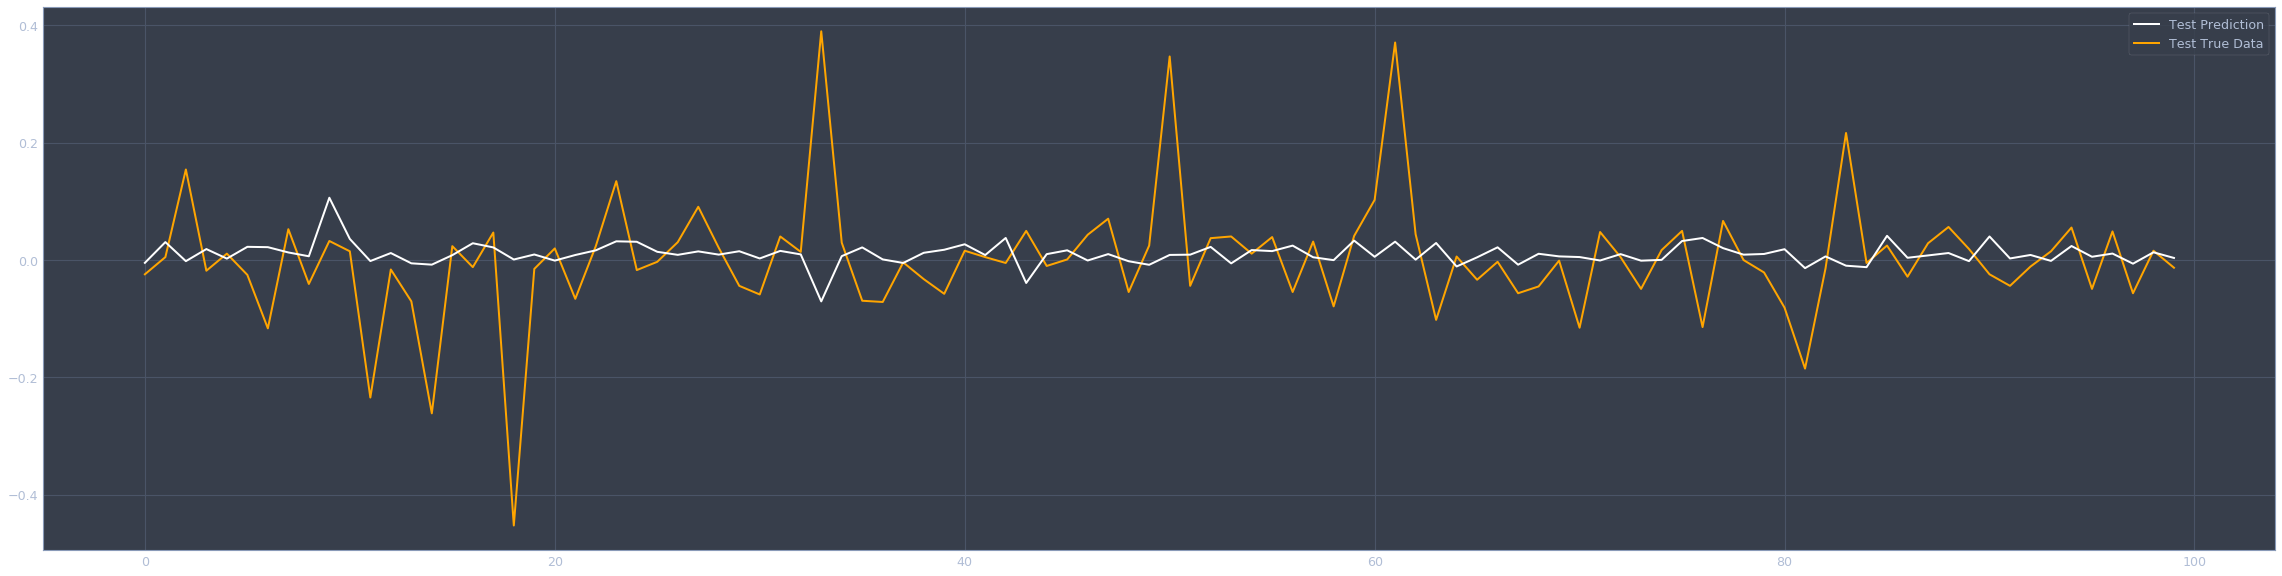

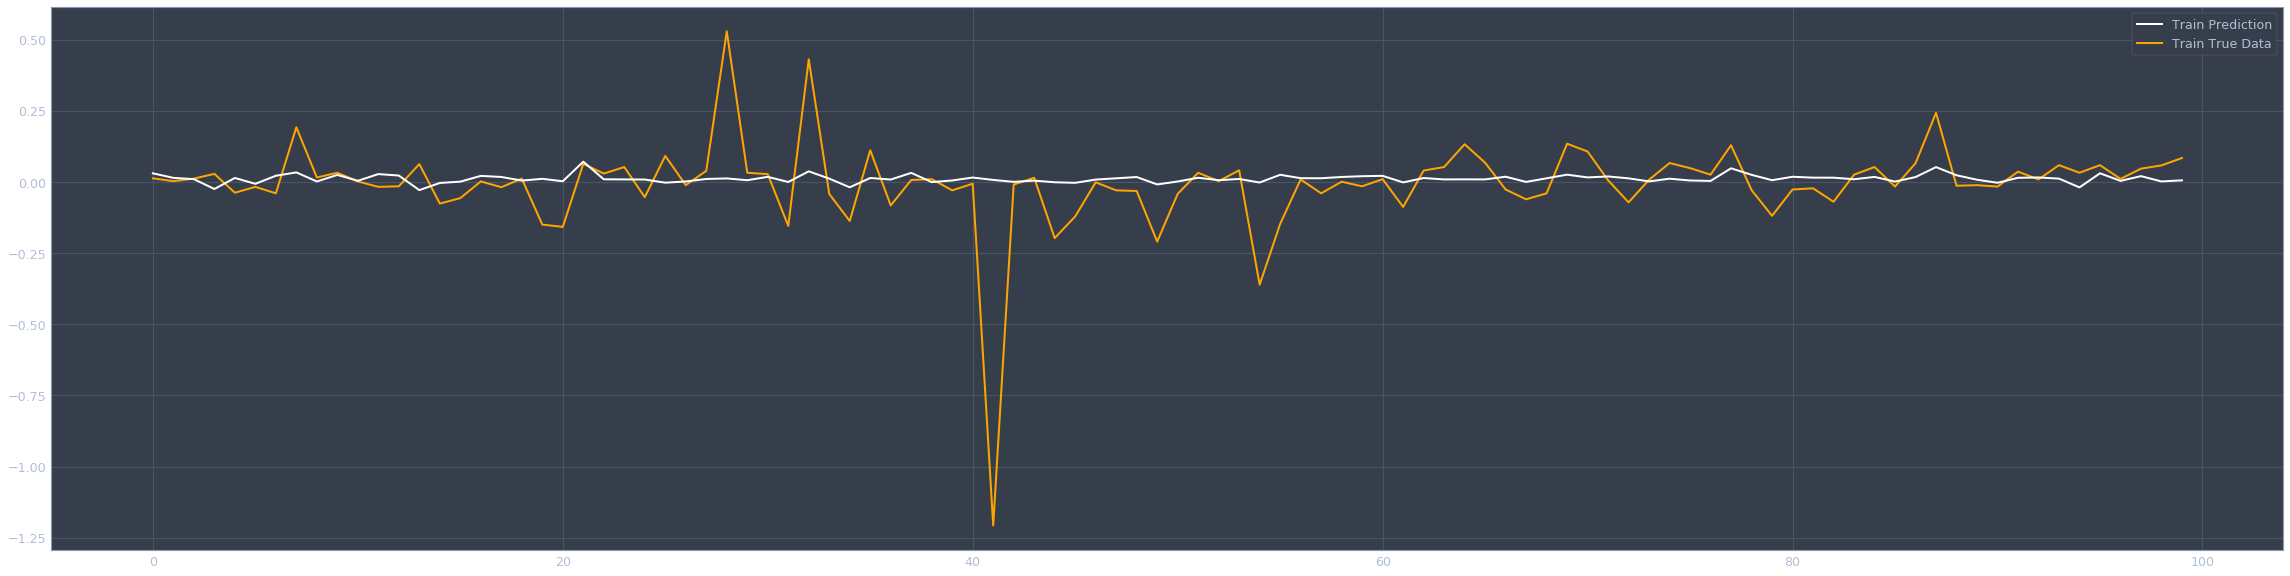

time: 2.25 s


In [117]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model_lr = LinearRegression()
# Fir the model to train data
model_lr.fit(x_train, y_train)
# Make a prediction for the test set
y_pred_lr_test = model_lr.predict(x_test)
y_pred_lr_train = model_lr.predict(x_train)
# Score the predictor on the test set
model_lr.score(x_test, y_test)
# Feature importance
feature_importance_lr = pd.DataFrame(model_lr.coef_, columns=['Weight'], index=new_sparse_columns).sort_values('Weight', ascending=False)
# Same R2 computation based but based on metrics library
print('R2 LR Test:', r2_score(y_test, y_pred_lr_test), 'Train:', r2_score(y_train, y_pred_lr_train))

sample = 100 # Number of records to look at - makes the visualisation more meaningful.
# Plot test true vs predicted values
plot_data(y_test, y_pred_lr_test, sample, 'Test', linewidth=2)
# Plot train true vs predicted values
plot_data(y_train, y_pred_lr_train, sample, 'Train', linewidth=2)

# XGB

In [118]:
import xgboost as xg
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

cv = 5
params={
    'max_depth':        [3], # shuld be 0.5 to 1% of the examples
    'subsample':        [1], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'min_child_weight': [10],
    #'colsample_bytree': [0.5], #[0.5,0.6,0.7,0.8],
    'objective':        ['reg:linear'],
    'n_estimators':     [1000], #[1000,2000,3000]
    'reg_alpha':        [0], #[0.01, 0.02, 0.03, 0.04]
    'learning_rate':    [0.1]
}

# Build XGB model based on the given parameters.
# Default features:
# max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', 
# booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
# subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None
xgb = xg.XGBRegressor()
xgb_gs =GridSearchCV(xgb, params, n_jobs=5, 
                   cv=TimeSeriesSplit(n_splits=cv).get_n_splits([x_train,y_train]), 
                   #scoring='neg_mean_absolute_error',
                   verbose=1, refit=True)

xgb_gs.fit(x_train, y_train)
print('Best estimator:',xgb_gs.best_estimator_)
# Predict estimated logerror
y_pred_xgb_test = xgb_gs.predict(x_test)
y_pred_xgb_train = xgb_gs.predict(x_train)
# Evaluate the performance of XGB
print('XGB R2 Test:', xgb_gs.score(x_test, y_test), 'Train:', xgb_gs.score(x_train, y_train))

# Show results for LR on train and test data
predicted_mae_lr_test = mean_absolute_error(y_test, y_pred_lr_test)
predicted_mae_lr_train = mean_absolute_error(y_train, y_pred_lr_train)
print('MAE LR  Train:', predicted_mae_lr_train, 'Test:',predicted_mae_lr_test)

# Show results for XGB on train and test data
predicted_mae_xgb_test = mean_absolute_error(y_test, y_pred_xgb_test)
predicted_mae_xgb_train = mean_absolute_error(y_train, y_pred_xgb_train)
print('MAE XGB Train:', predicted_mae_xgb_train, 'Test:',predicted_mae_xgb_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 10.0min remaining: 15.1min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 10.1min finished


Best estimator: XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=10, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
XGB R2 Test: 0.0133306986217 Train: 0.117131906148
MAE LR  Train: 0.0683206992786 Test: 0.0704654732375
MAE XGB Train: 0.0666665452465 Test: 0.0715850351294
time: 16min 9s


In [49]:
submission_sample

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0
5,10898347,0,0,0,0,0,0
6,10933547,0,0,0,0,0,0
7,10940747,0,0,0,0,0,0
8,10954547,0,0,0,0,0,0
9,10976347,0,0,0,0,0,0


time: 23 ms
